## FPA

This class represents standard Cuckoo Search based on the explanation in the [\[book\]](https://doi.org/10.1016/B978-0-12-416743-8.00009-9) Nature-Inspired Optimization Algorithms by Xin-She Yang and his implementation of standard Cuckoo Search in Matlab on [\[mathworks\]](https://www.mathworks.com/matlabcentral/fileexchange/29809-cuckoo-search-cs-algorithm). The implementation is slightly different to the flow of the algorithm described in the book. The figures below describe the pseudocode of the algorithm from the book, and the flow of the implementation. The GRW stands for Global Random Walk by Levy Flight, and the LRW stands for Local Random Walk.

1) **Initial Population:**: A starting population is sampled in the beginning. In this framework, this can be either a [Sampling](../operators/sampling.ipynb) object, which defines different initial sampling strategies, or `Population` where the `X` and `F` values are set, or a simple NumPy array (pop_size x n_var).

2) **Evaluation:** It is executed using the problem defined to be solved.

3) **Survival:** The survival mechanism used is by default the survival of the fittest for the Elitism.

4) **Global Random Walk:** The global random walks use a step size that is generated based on Levy Flight Distribution. Every dimension will have its own randomly generated step size on every operation. The Global Random Walk can be done following the book which to randomly choose solution $x_{i}$ which will be modified by Global Random Walk resulting in $x'_i$ and replace a randomly chosen solution $x_{j}$, if $x'_{i}$ is better than $x_{j}$. However for simplicity sake, as also been done in the matlab implementation, $x'_{i}$ will be compared to $x_{i}, \forall i$ in every iteration. 

5) **Local Random Walk:** After the Global Random Walk has been done, including the replacement after improvement, every nest $x_i$ has a $p_a$ probability to create new solution via Local Ranom Walk $x'_i = x_i + \alpha_0*(x_j-x_k)$ with $x_j$ and $x_k$ are two different randomly selected nest. Afterwards, combine the old nests with the new generated nests via Local Random Walks. The size of the combined nests will be pop_size $\leq$ combined_pop_size $\leq 2$pop_size. Survival mechanism thus will be used to select a number of pop_size best nests.



<div style="display: block;margin-left: auto;margin-right: auto;width: 60%;">
![cs_pseudocode](../resources/images/cuckoo_search_pseudocode.png)
</div>

<div style="display: block;margin-left: auto;margin-right: auto;width: 60%;">
![cs_flow](../resources/images/cuckoo_search_flow.png)
</div>

### Example

3.3755383491516113


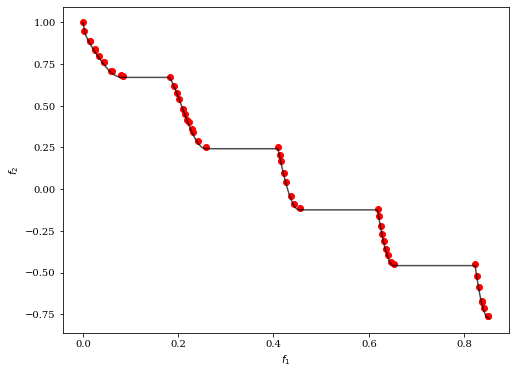

In [31]:
from pymoo.algorithms.mofpa import MOFPA
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt3")

algorithm = MOFPA()

res = minimize(problem, algorithm, ('n_gen', 500), verbose=False)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, color="red")
plot.show()

### API